<a href="https://colab.research.google.com/github/tikoosaksham/data_analysis/blob/master/LSTMStockPrediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [36]:
import pandas_datareader as pdr
import numpy as np
from numpy import array
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

import math
from sklearn.metrics import mean_squared_error

In [4]:
df = pdr.get_data_tiingo('AAPL', api_key="removed")

In [5]:
df.to_csv("AAPL.csv")

In [6]:
df1 = df.reset_index()["close"]

In [7]:
df1.shape

(1258,)

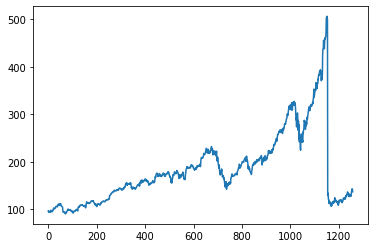

In [8]:
plt.plot(df1)

In [9]:
scaler = MinMaxScaler(feature_range = (0, 1))
df1 = scaler.fit_transform(np.array(df1).reshape(-1, 1))

In [10]:
training_size = int(len(df1) * 0.65)
test_size = len(df1) - training_size
train_data,test_data = df1[0 : training_size, :], df1[training_size : len(df1), :1]

In [11]:
training_size, test_size

(817, 441)

In [13]:
def create_dataset(dataset, time_step = 1):
	dataX, dataY = [], []

	for i in range(len(dataset) - time_step - 1):
		a = dataset[i: (i + time_step), 0]
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
  
	return np.array(dataX), np.array(dataY)
 
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [16]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [18]:
model = Sequential()
model.add(LSTM(50,return_sequences = True, input_shape=(100, 1)))
model.add(LSTM(50,return_sequences = True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [19]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100, 50)           10400     
_________________________________________________________________
lstm_1 (LSTM)                (None, 100, 50)           20200     
_________________________________________________________________
lstm_2 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [20]:
model.fit(X_train, y_train, validation_data = (X_test, ytest), epochs=100, batch_size=64, verbose=1)

Epoch 1/100
12/12 [==============================] - 8s 269ms/step - loss: 0.0168 - val_loss: 0.0511
Epoch 2/100
12/12 [==============================] - 2s 165ms/step - loss: 0.0029 - val_loss: 0.0238
Epoch 3/100
12/12 [==============================] - 2s 165ms/step - loss: 0.0014 - val_loss: 0.0217
Epoch 4/100
12/12 [==============================] - 2s 179ms/step - loss: 4.8028e-04 - val_loss: 0.0198
Epoch 5/100
12/12 [==============================] - 2s 168ms/step - loss: 3.6038e-04 - val_loss: 0.0187
Epoch 6/100
12/12 [==============================] - 2s 171ms/step - loss: 3.1458e-04 - val_loss: 0.0184
Epoch 7/100
12/12 [==============================] - 2s 170ms/step - loss: 3.6324e-04 - val_loss: 0.0177
Epoch 8/100
12/12 [==============================] - 2s 170ms/step - loss: 2.7638e-04 - val_loss: 0.0173
Epoch 9/100
12/12 [==============================] - 2s 170ms/step - loss: 3.1940e-04 - val_loss: 0.0168
Epoch 10/100
12/12 [==============================] - 2s 176ms/step

In [24]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

In [29]:
math.sqrt(mean_squared_error(y_train, train_predict))

161.3503722468358

In [31]:
math.sqrt(mean_squared_error(ytest, test_predict))

254.22824210900285

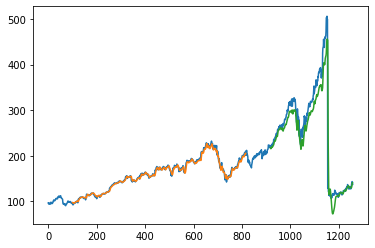

In [33]:

### Plotting 
# shift train predictions for plotting
look_back = 100
trainPredictPlot = np.empty_like(df1)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back : len(train_predict) + look_back, :] = train_predict

# shift test predictions for plotting
testPredictPlot = np.empty_like(df1)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict) + (look_back*2) + 1 : len(df1) - 1, :] = test_predict

# plot baseline and predictions
plt.plot(scaler.inverse_transform(df1))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [34]:
x_input = test_data[341 : ].reshape(1, -1)
x_input.shape

(1, 100)

In [35]:
temp_input = list(x_input)
temp_input = temp_input[0].tolist()

In [ ]:
# prediction for next 30 days

lst_output = []
n_steps = 100
for i in range (30):
    if(len(temp_input) > 100):
        x_input = np.array(temp_input[1:])
        print("{} Day input {}".format(i, x_input))
        x_input=x_input.reshape(1, -1)
        x_input = x_input.reshape((1, n_steps, 1))
        
        yhat = model.predict(x_input, verbose = 0)
        print("{} Day output {}".format(i, yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]
        
        lst_output.extend(yhat.tolist())
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())

In [38]:
day_new = np.arange(1, 101)
day_pred = np.arange(101, 131)

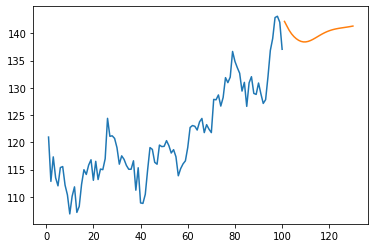

In [43]:
plt.plot(day_new,scaler.inverse_transform(df1[-100 : ]))
plt.plot(day_pred,scaler.inverse_transform(lst_output))